# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

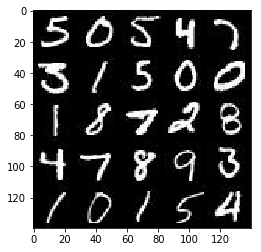

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

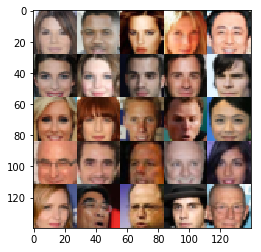

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data, learning rate)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/usr/lo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28ximage_channels
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 2x2x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [20]:
def train(epoch_count, batch_size, z_dim, learn_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learn_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)    

    samples, losses = [], []
    steps = 0
    print_every=10
    show_every=100
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Scale up the input values from -0.5:0.5 to -1:1 by multiplying by 2.0
                x = 2.0 * batch_images
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: x, input_z: batch_z, learning_rate: learn_rate})
                _ = sess.run(d_opt, feed_dict={input_real: x, input_z: batch_z, learning_rate: learn_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: x, learning_rate: learn_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: x, learning_rate: learn_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: x, learning_rate: learn_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: x})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

    return                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.1546... Generator Loss: 0.2276
Epoch 1/2... Discriminator Loss: 1.1439... Generator Loss: 0.9475
Epoch 1/2... Discriminator Loss: 2.3964... Generator Loss: 0.3140
Epoch 1/2... Discriminator Loss: 0.8445... Generator Loss: 1.4209
Epoch 1/2... Discriminator Loss: 1.7479... Generator Loss: 0.4087
Epoch 1/2... Discriminator Loss: 1.6912... Generator Loss: 0.5673
Epoch 1/2... Discriminator Loss: 1.3865... Generator Loss: 0.6237
Epoch 1/2... Discriminator Loss: 1.4354... Generator Loss: 0.5461
Epoch 1/2... Discriminator Loss: 1.5479... Generator Loss: 0.5400
Epoch 1/2... Discriminator Loss: 1.4342... Generator Loss: 0.5551


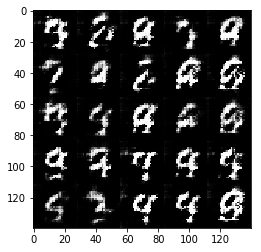

Epoch 1/2... Discriminator Loss: 1.7018... Generator Loss: 0.3936
Epoch 1/2... Discriminator Loss: 1.5382... Generator Loss: 0.4767
Epoch 1/2... Discriminator Loss: 1.5269... Generator Loss: 0.5397
Epoch 1/2... Discriminator Loss: 1.6393... Generator Loss: 0.4201
Epoch 1/2... Discriminator Loss: 1.5134... Generator Loss: 0.5202
Epoch 1/2... Discriminator Loss: 1.4074... Generator Loss: 0.6242
Epoch 1/2... Discriminator Loss: 1.5590... Generator Loss: 0.5463
Epoch 1/2... Discriminator Loss: 1.5036... Generator Loss: 0.4972
Epoch 1/2... Discriminator Loss: 1.5868... Generator Loss: 0.5589
Epoch 1/2... Discriminator Loss: 1.4839... Generator Loss: 0.5271


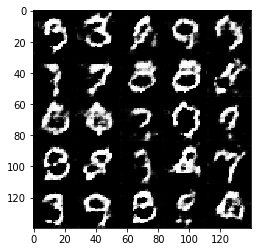

Epoch 1/2... Discriminator Loss: 1.5270... Generator Loss: 0.4631
Epoch 1/2... Discriminator Loss: 1.6809... Generator Loss: 0.3893
Epoch 1/2... Discriminator Loss: 1.4456... Generator Loss: 0.5831
Epoch 1/2... Discriminator Loss: 1.5239... Generator Loss: 0.5062
Epoch 1/2... Discriminator Loss: 1.5539... Generator Loss: 0.4410
Epoch 1/2... Discriminator Loss: 1.4449... Generator Loss: 0.5862
Epoch 1/2... Discriminator Loss: 1.4516... Generator Loss: 0.5877
Epoch 1/2... Discriminator Loss: 1.5701... Generator Loss: 0.5413
Epoch 1/2... Discriminator Loss: 1.6344... Generator Loss: 0.4495
Epoch 1/2... Discriminator Loss: 1.4016... Generator Loss: 0.6307


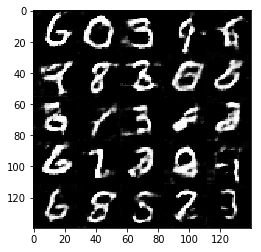

Epoch 1/2... Discriminator Loss: 1.5837... Generator Loss: 0.4734
Epoch 1/2... Discriminator Loss: 1.5357... Generator Loss: 0.4452
Epoch 1/2... Discriminator Loss: 1.5970... Generator Loss: 0.4466
Epoch 1/2... Discriminator Loss: 1.5073... Generator Loss: 0.5261
Epoch 1/2... Discriminator Loss: 1.5825... Generator Loss: 0.4706
Epoch 1/2... Discriminator Loss: 1.6972... Generator Loss: 0.3724
Epoch 1/2... Discriminator Loss: 1.5498... Generator Loss: 0.4726
Epoch 1/2... Discriminator Loss: 1.4328... Generator Loss: 0.7101
Epoch 1/2... Discriminator Loss: 1.5934... Generator Loss: 0.4709
Epoch 1/2... Discriminator Loss: 1.5752... Generator Loss: 0.4357


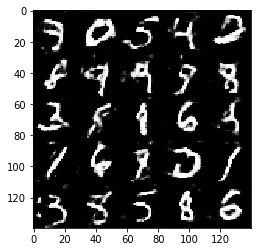

Epoch 1/2... Discriminator Loss: 1.7333... Generator Loss: 0.3564
Epoch 1/2... Discriminator Loss: 1.5007... Generator Loss: 0.5359
Epoch 1/2... Discriminator Loss: 1.6077... Generator Loss: 0.4220
Epoch 1/2... Discriminator Loss: 1.6323... Generator Loss: 0.3864
Epoch 1/2... Discriminator Loss: 1.5532... Generator Loss: 0.4561
Epoch 1/2... Discriminator Loss: 2.1609... Generator Loss: 0.2057
Epoch 2/2... Discriminator Loss: 1.5587... Generator Loss: 0.4936
Epoch 2/2... Discriminator Loss: 1.4372... Generator Loss: 0.5763
Epoch 2/2... Discriminator Loss: 1.6146... Generator Loss: 0.5128
Epoch 2/2... Discriminator Loss: 1.7619... Generator Loss: 0.3490


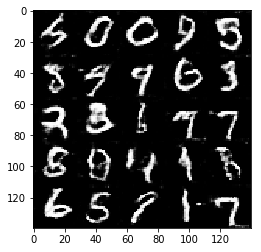

Epoch 2/2... Discriminator Loss: 1.5743... Generator Loss: 0.5376
Epoch 2/2... Discriminator Loss: 1.6984... Generator Loss: 0.3593
Epoch 2/2... Discriminator Loss: 1.6251... Generator Loss: 0.3823
Epoch 2/2... Discriminator Loss: 1.5350... Generator Loss: 0.6038
Epoch 2/2... Discriminator Loss: 1.5522... Generator Loss: 0.4405
Epoch 2/2... Discriminator Loss: 1.9698... Generator Loss: 0.2559
Epoch 2/2... Discriminator Loss: 1.7334... Generator Loss: 0.3450
Epoch 2/2... Discriminator Loss: 1.5797... Generator Loss: 0.4409
Epoch 2/2... Discriminator Loss: 1.7248... Generator Loss: 0.3982
Epoch 2/2... Discriminator Loss: 1.4845... Generator Loss: 0.5529


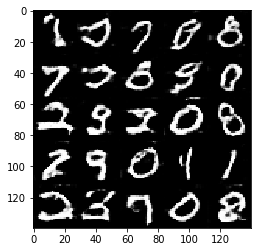

Epoch 2/2... Discriminator Loss: 1.5688... Generator Loss: 0.4992
Epoch 2/2... Discriminator Loss: 2.0659... Generator Loss: 0.2314
Epoch 2/2... Discriminator Loss: 1.4583... Generator Loss: 0.5389
Epoch 2/2... Discriminator Loss: 1.7734... Generator Loss: 0.3695
Epoch 2/2... Discriminator Loss: 1.9053... Generator Loss: 0.2871
Epoch 2/2... Discriminator Loss: 1.7006... Generator Loss: 0.3684
Epoch 2/2... Discriminator Loss: 1.6234... Generator Loss: 0.3882
Epoch 2/2... Discriminator Loss: 2.0182... Generator Loss: 0.2503
Epoch 2/2... Discriminator Loss: 1.5673... Generator Loss: 0.4417
Epoch 2/2... Discriminator Loss: 1.5343... Generator Loss: 0.4680


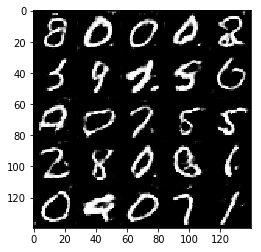

Epoch 2/2... Discriminator Loss: 1.4652... Generator Loss: 0.5072
Epoch 2/2... Discriminator Loss: 1.5560... Generator Loss: 0.4416
Epoch 2/2... Discriminator Loss: 1.6553... Generator Loss: 0.3883
Epoch 2/2... Discriminator Loss: 1.6583... Generator Loss: 0.3922
Epoch 2/2... Discriminator Loss: 2.2949... Generator Loss: 0.1883
Epoch 2/2... Discriminator Loss: 1.7094... Generator Loss: 0.3585
Epoch 2/2... Discriminator Loss: 1.4642... Generator Loss: 0.5196
Epoch 2/2... Discriminator Loss: 1.4723... Generator Loss: 0.6767
Epoch 2/2... Discriminator Loss: 1.6614... Generator Loss: 0.4226
Epoch 2/2... Discriminator Loss: 1.7702... Generator Loss: 0.3940


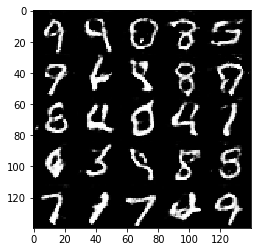

Epoch 2/2... Discriminator Loss: 1.5740... Generator Loss: 0.4297
Epoch 2/2... Discriminator Loss: 1.6822... Generator Loss: 0.3515
Epoch 2/2... Discriminator Loss: 1.8077... Generator Loss: 0.3229
Epoch 2/2... Discriminator Loss: 1.9227... Generator Loss: 0.2868
Epoch 2/2... Discriminator Loss: 2.9149... Generator Loss: 0.1084
Epoch 2/2... Discriminator Loss: 2.0112... Generator Loss: 0.2493
Epoch 2/2... Discriminator Loss: 1.7002... Generator Loss: 0.3845
Epoch 2/2... Discriminator Loss: 2.7386... Generator Loss: 0.1215
Epoch 2/2... Discriminator Loss: 1.4774... Generator Loss: 0.5168
Epoch 2/2... Discriminator Loss: 1.9774... Generator Loss: 0.3048


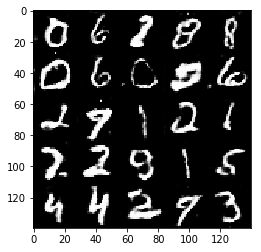

Epoch 2/2... Discriminator Loss: 1.4358... Generator Loss: 0.5454
Epoch 2/2... Discriminator Loss: 2.1654... Generator Loss: 0.2161
Epoch 2/2... Discriminator Loss: 1.4666... Generator Loss: 0.5376


In [21]:
batch_size = 128
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.1145... Generator Loss: 0.0360
Epoch 1/1... Discriminator Loss: 0.9114... Generator Loss: 2.9033
Epoch 1/1... Discriminator Loss: 1.1086... Generator Loss: 3.0257
Epoch 1/1... Discriminator Loss: 0.9442... Generator Loss: 1.7945
Epoch 1/1... Discriminator Loss: 1.9726... Generator Loss: 0.4918
Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.5781
Epoch 1/1... Discriminator Loss: 1.6465... Generator Loss: 0.5676
Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.6031
Epoch 1/1... Discriminator Loss: 1.5077... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.7675... Generator Loss: 0.5335


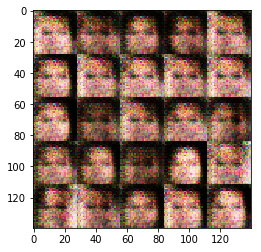

Epoch 1/1... Discriminator Loss: 1.7076... Generator Loss: 0.6143
Epoch 1/1... Discriminator Loss: 1.5237... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 1.5517... Generator Loss: 0.5658
Epoch 1/1... Discriminator Loss: 1.8140... Generator Loss: 0.4883
Epoch 1/1... Discriminator Loss: 1.4996... Generator Loss: 0.6032
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.6904... Generator Loss: 0.5188
Epoch 1/1... Discriminator Loss: 1.5056... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.5837... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 1.5119... Generator Loss: 0.6600


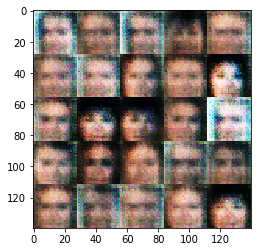

Epoch 1/1... Discriminator Loss: 1.6368... Generator Loss: 0.6296
Epoch 1/1... Discriminator Loss: 1.5001... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.5888... Generator Loss: 0.6056
Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.5852... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.4679... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.5349... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 1.4663... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.5920... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.8264


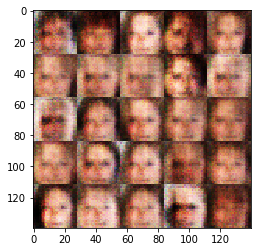

Epoch 1/1... Discriminator Loss: 1.6794... Generator Loss: 0.5575
Epoch 1/1... Discriminator Loss: 1.4802... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.4936... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.5860... Generator Loss: 0.5940
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.5665... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.5038... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.5124... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.4941... Generator Loss: 0.6949


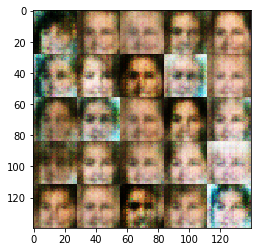

Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.7518
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.6939... Generator Loss: 0.5291
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.4952... Generator Loss: 0.6986


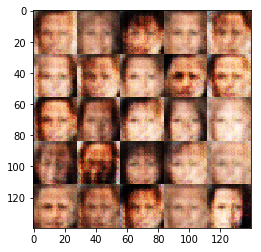

Epoch 1/1... Discriminator Loss: 1.4656... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.5414... Generator Loss: 0.6326
Epoch 1/1... Discriminator Loss: 1.5256... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.4883... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 1.4953... Generator Loss: 0.6997
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.7876


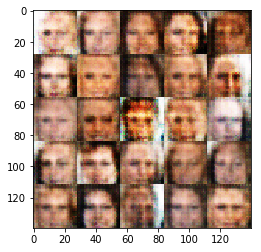

Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 0.7027
Epoch 1/1... Discriminator Loss: 1.5110... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.4725... Generator Loss: 0.7226
Epoch 1/1... Discriminator Loss: 1.4982... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.5063... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 1.5200... Generator Loss: 0.6774


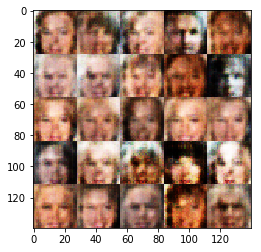

Epoch 1/1... Discriminator Loss: 1.4962... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 1.4600... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.7249


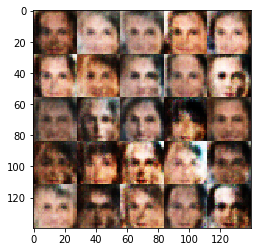

Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 1.4642... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.7385
Epoch 1/1... Discriminator Loss: 1.4527... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.6833


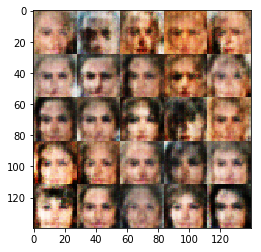

Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.4912... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.7279
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.7566


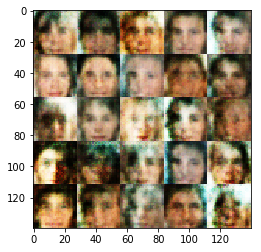

Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 1.5092... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 1.4498... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.7452


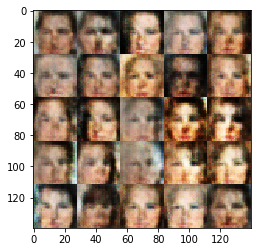

Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.4710... Generator Loss: 0.7175
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.7455
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.8055


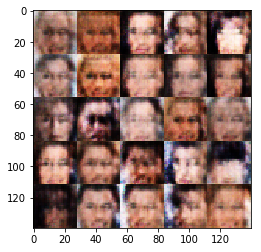

Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.5291... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.7795


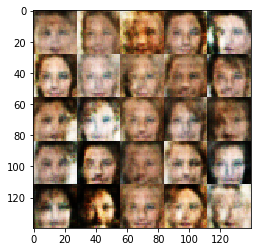

Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.7198
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.7143


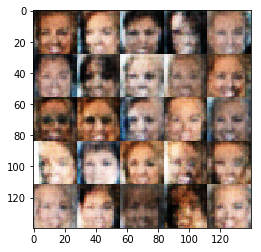

Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.4747... Generator Loss: 0.7124
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.7357


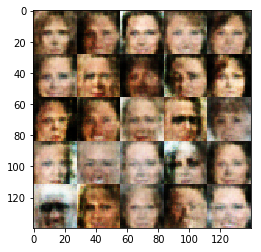

Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 1.4704... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.4951... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7212


In [22]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.